# RDFIA: Practical work 3-b
## Approximate Inference in Classification
### Sorbonne Université 2024/25
### [Course link](https://rdfia.github.io/)
### GRUSS Carlos, RCHAKI Oussama

In classification taks, even for a mere Logistic Regression, we don't have access to a closed form of the posterior $p(\pmb{w} \vert \mathcal{D})$. Unlike in Linear regression, the likelihood isn't conjugated to the Gaussian prior anymore. We will need to approximate this posterior.

During this session, we will explore and compare approximate inference approaches on 2D binary classification datasets. Studied approaches include Laplacian approximation, variational inference with mean-field approximation and Monte Carlo dropout.

**Goal:** Take hand on approximate inference methods and understand how they works on linear and non-linear 2D datasets.

### All Imports and Useful Functions

Here we are going to install and import everything we are going to need for this tutorial. 

**Note:** *You can double-click the title of the collapsed cells (as the ones below) to expand them and read their content.*

In [1]:
# @title Import libs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from IPython import display
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import grad
import torch.distributions as dist

In [2]:
# @title Useful plot function 
def plot_decision_boundary(model, X, Y, epoch, accuracy, model_type='classic', 
                           nsamples=100, posterior=None, tloc=(-4,-7), 
                           nbh=2, cmap='RdBu', comment=''):    
    """ Plot and show learning process in classification """
    h = 0.02*nbh
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min*2, x_max*2, h),
                         np.arange(y_min*2, y_max*2, h))
    
    test_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.FloatTensor)
    model.eval()
    with torch.no_grad():
        if model_type=='classic':
            pred = torch.sigmoid(model(test_tensor))
        elif model_type=='laplace':
            #Save original mean weight
            original_weight = model.state_dict()['fc.weight'].detach().clone()
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                state_dict = model.state_dict()
                state_dict['fc.weight'] = torch.from_numpy(posterior[i].reshape(1,2))
                model.load_state_dict(state_dict)
                outputs[i] = torch.sigmoid(model(test_tensor))
            
            pred = outputs.mean(0).squeeze()
            state_dict['fc.weight'] = original_weight
            model.load_state_dict(state_dict)
        elif model_type=='vi':
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)
                
            pred = outputs.mean(0).squeeze()
        elif model_type=='mcdropout':
            model.eval()
            model.training = True
            outputs = torch.zeros(nsamples, test_tensor.shape[0], 1)
            for i in range(nsamples):
                outputs[i] = model(test_tensor)
            
            pred = outputs.mean(0).squeeze()
    
    Z = pred.reshape(xx.shape).detach().numpy()

    plt.cla()
    ax.set_title(f'Classification Analysis {comment}')
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.25)
    ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=0.7)
    ax.scatter(X[:,0], X[:,1], c=Y, cmap='Paired_r', edgecolors='k');
    ax.text(tloc[0], tloc[1], f'Epoch = {epoch+1}, Accuracy = {accuracy:.2%}', fontdict={'size': 12, 'fontweight': 'bold'})
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Part I: Bayesian Logistic Regression

In linear regression, model prediction is of the continuous form $f(\pmb{x})=\pmb{w}^T\pmb{x}+b$.

For classification, we wish to predict discrete class labels $\mathcal{C}_k$ to a sample $\pmb{x}$. 
For simplicity, let's consider here binary classification:
$$f(\pmb{x}) = \sigma(\pmb{w}^T\pmb{x} + b)$$
where $\sigma(t)= \frac{1}{1+e^t}$ is the sigmoid function.

As in linear regression, we define a Gaussian prior: 
$$ p(\pmb{w}) = \mathcal{N}(\pmb{w}; \pmb{\mu}_0, \pmb{\Sigma}_0^2) $$
Unfortunately, the posterior distribution isn't tractable as the likelihood isn't conjugate to the prior anymore.

We will explore in the following different methods to obtain an estimate of the posterior distribution and hence the predictive distribution.

### I.0 Dataset

In [3]:
# @title Hyperparameters for model and approximate inference { form-width: "30%" }
WEIGHT_DECAY = 5e-2    # @param
NB_SAMPLES = 400    # @param
TEXT_LOCATION = (-5,  -7)

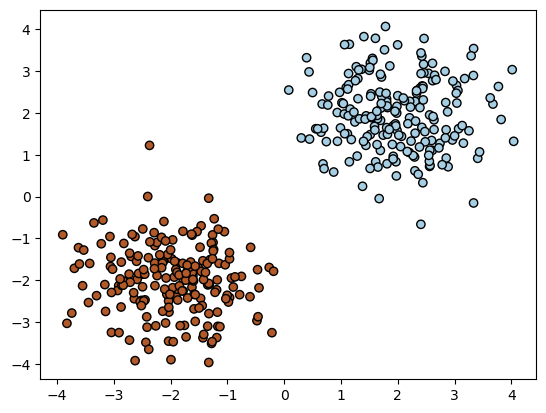

In [4]:
# Load linear dataset
X, y = make_blobs(n_samples=NB_SAMPLES, centers=[(-2,-2),(2,2)], cluster_std=0.80, n_features=2)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### I.1 Maximum-A-Posteriori Estimate


In this "baseline", we reduce our posterior distribution $p(\pmb{w} | \mathcal{D})$ to a point estimate $\pmb{w}_{MAP}$. For a new sample $\pmb{x^*}$, the predictive distribution can then be approximated by
$$ p(\mathbf{y} = 1|\pmb{x^*},\mathcal{D}) = \int p(\mathbf{y} =1 |\pmb{x},\pmb{w})p(\pmb{w} | \mathcal{D})d\pmb{w} \approx p(y =1 |\pmb{x},\pmb{w}_{\textrm{MAP}}).$$
This approximation is called the **plug-in approximation**.

The point estimate corresponds to the Maximum-A-Posteriori minimum given by:
$$ \pmb{w}_{\textrm{MAP}} = arg \max_{\pmb{w}} p(\pmb{w} \vert \mathcal{D}) = arg \max_{\pmb{w}} p(\mathcal{D} \vert \pmb{w})p(\pmb{w}) = arg \max_{\pmb{w}} \prod_{n=1}^N p(y_n \vert \pmb{x}_n, \pmb{w})p(\pmb{w}) $$
Looking for the maximum solution of previous equation is equivalent to the minimum solution of $- \log p(\pmb{w} \vert \mathcal{D})$. In case of a Gaussian prior, it can further be derived as:
$$ \pmb{w}_{\textrm{MAP}} = arg \min_{\pmb{w}} \sum_{n=1}^N \big ( -y_n \log \sigma(\pmb{w}^T \pmb{x}_n + b) - (1-y_n) \log (1 - \sigma(\pmb{w}^T \pmb{x}_n + b)) + \frac{1}{2 \sigma_0^2} \vert \vert \pmb{w} \vert \vert_2^2 \big ) $$

Note that:
- This actually correspond to the minimum given by the standard **cross-entropy** loss in classification with a weight decay regularization
- Unlike in linear regression, $\pmb{w}_{MAP}$ **cannot be computed analytically**
- But we can use optimization methods to compute it, e.g. **stochastic gradient descent**
- Nevertheless, we only obtain a **point-wise estimate**, and not a full distribution over parameters $\pmb{w}$


Consequently, **the objective is simply to implement and train a Logistic Regression model** with Pytorch and then compute $p(\mathbf{y} = 1|\pmb{x}^*,\mathcal{D})$ on a new sample $\pmb{x}^*$ as in a deterministic model.

In [5]:
class LogisticRegression(nn.Module):
    """ A Logistic Regression Model with sigmoid output in Pytorch"""
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x)

In [6]:
def accuracy(Yhat, Y):
    acc = (torch.sum(torch.argmax(Yhat, dim=1) == Y) / Y.size(0)) * 100
    return acc

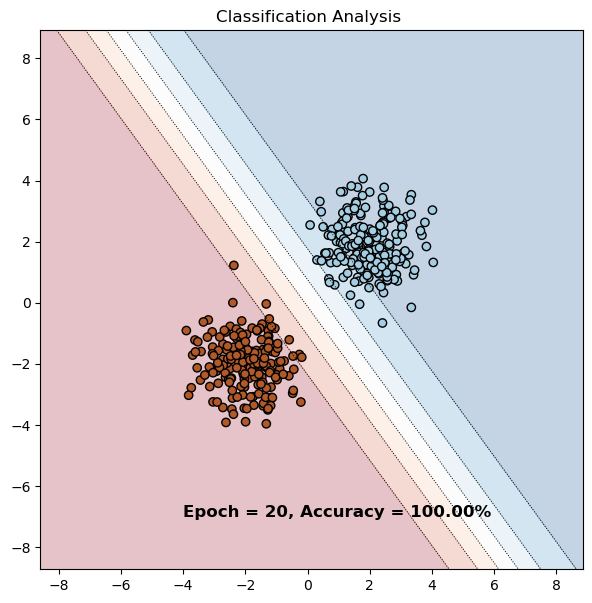

In [7]:
# @title **[CODING TASK]** Train a Logistic Regression model with stochastic gradient descent for 20 epochs.

net = LogisticRegression(input_size=X.shape[1])
net.train()
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-2)

X_train = torch.tensor(X, dtype=torch.float32)  # Convertir en tenseur Float
y_train = torch.tensor(y, dtype=torch.long)

fig, ax = plt.subplots(figsize=(7, 7))

# Train previously defined network for 20 epochs with SGD
# and plot result for each epoch by uncommenting function below
for epoch in range(20):  # loop over the dataset multiple times
    for X_batch, Y_batch in train_dataloader:  # Itérer sur les mini-batches
        optimizer.zero_grad()
        Yhat = net(X_batch).squeeze()  # Prédictions pour le batch actuel
        L = criterion(Yhat, Y_batch)  # Calcul de la perte et de la précision
        L.backward()
        optimizer.step()
    print(epoch)
    Yhat = torch.sigmoid(net(X_train))
    accuracy = (torch.sum((Yhat > 0.5).squeeze().long() == y_train) / y_train.size(0))
    plot_decision_boundary(net, X, y, epoch, accuracy, model_type='classic',
                           nsamples=100, posterior=None, tloc=(-4, -7),
                           nbh=2, cmap='RdBu')

**[Question 1.1]: Analyze the results provided by previous plot. Looking at $p(\mathbf{y}=1 | \pmb{x}, \pmb{w}_{\textrm{MAP}})$, what can you say about points far from train distribution?**

The figure displays a clear decision boundary that effectively separates the two classes. The boundary aligns well with the distribution of the training points, as shown in the colored regions (red and blue). However, the model fails to account for the lack of training data in distant regions, resulting in predictions that do not adequately reflect epistemic uncertainty (uncertainty due to a lack of data). Ideally, a Bayesian model would produce higher uncertainty in regions far from the training points, which is not observed in the figure above. This leads us to conclude that a more precise method of approximation would be preferable. 

It is worth mentioning that we can observe some uncertainty regions in the graph. These represent aleatoric uncertainty, as the model, in these regions (near the decision boundary), cannot confidently determine if a training point is an outlier (affected by aleatoric noise) or not.


### I.2 Laplace Approximation


Nous utiliserons l'approximation de Laplace pour estimer la distribution a posteriori intractable $p(\pmb{w} \vert \mathcal{D})$.

Ici, $p(\pmb{w} \vert \mathcal{D})$ est approximée par une distribution normale $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{\text{lap}}, \pmb{\Sigma}_{\text{lap}}^2)$, où :

- La moyenne de la distribution normale $\pmb{\mu}_{\text{lap}}$ correspond au mode de $p(\pmb{w} \vert \mathcal{D})$. En d'autres termes, cela revient à prendre les poids optimaux obtenus par une estimation du Maximum A Posteriori (MAP) :
$$
\pmb{\mu}_{\text{lap}} = \pmb{w}_{\text{MAP}} = \arg \min_{\pmb{w}} -\log p(\pmb{w} \vert \mathcal{D}).
$$
- La matrice de covariance est obtenue en calculant le Hessien de la fonction de perte $-\log p(\pmb{w} \vert \mathcal{D})$ en $\pmb{w} = \pmb{w}_{\text{MAP}}$ :
$$
(\pmb{\Sigma}^2_{\text{lap}})^{-1} = \nabla\nabla_{\pmb{w}} [-\log p(\pmb{w} \vert \mathcal{D})]_{\pmb{w} = \pmb{w}_{\text{MAP}}}.
$$


In [8]:
# @title **[CODING TASK]** Extract μ_lap from previously trained model
# NB: Select only weights parameters (without bias)
w_map = net.fc.weight

To compute the Hessian, we first compute the gradient at $\pmb{w}_{\textrm{MAP}}$:

In [9]:
# Computing first derivative w.r.t to model's weights
optimizer.zero_grad()
output = net(X).squeeze()
loss = criterion(output, y) + WEIGHT_DECAY*net.fc.weight.norm()**2
gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]

In [10]:
# Compute the Hessian matrix
hess_weights = []
for g in gradf_weight.view(-1):
    hess_row = grad(g, net.fc.weight, retain_graph=True)[0]
    hess_weights.append(hess_row.view(-1))

# We concatenate rows to form the Hessian matrix
hess_weights = torch.stack(hess_weights).view(
    net.fc.weight.numel(), net.fc.weight.numel())

# We add a small value to the diagonal for numerical stability (regularization)
epsilon = 1e-5

Sigma_laplace = torch.inverse(hess_weights + epsilon * torch.eye(hess_weights.size(0)))

hess_weights_np = hess_weights.detach().numpy()
Sigma_laplace_np = Sigma_laplace.detach().numpy()

print("Hessian matrix:\n", hess_weights)
print("Covariance matrix (Sigma Laplace):\n", Sigma_laplace)

Hessian matrix:
 tensor([[0.2364, 0.1135],
        [0.1135, 0.2559]])
Covariance matrix (Sigma Laplace):
 tensor([[ 5.3744, -2.3845],
        [-2.3845,  4.9657]])


We now compute the posterior approximate $\mathcal{N}(\pmb{w} ; \pmb{\mu}_{lap}, \pmb{\Sigma}_{lap}^2)$ with the parameters found. 

Given this distribution, we can compute the posterior thanks to Monte-Carlo sampling and plot results for the last epoch corresponding to $\pmb{w}_{\textrm{MAP}}$:

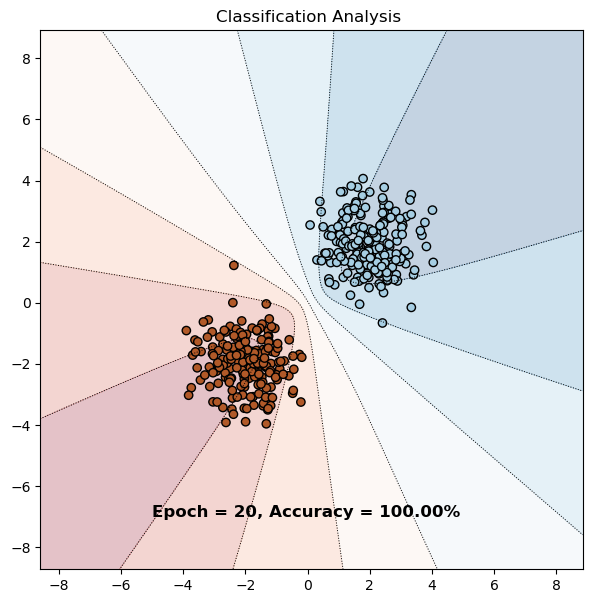

In [11]:
# Defining posterior distribution
laplace_posterior = np.random.multivariate_normal(w_map.detach().numpy().reshape(2,), Sigma_laplace.detach().numpy(), NB_SAMPLES)

# Plotting results 
fig, ax = plt.subplots(figsize=(7, 7))  
plot_decision_boundary(net, X, y, epoch, ((output.squeeze() >= 0.0) == y).float().mean(), model_type='laplace',
                       tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior)

**[Question 1.2]: Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave?**

The plot illustrates a decision boundary that separates the two classes, with probabilistic predictions represented across the feature space. Unlike the Maximum A Posteriori (MAP) estimate in the previous plot, which relied on a single point estimate of the weights and produced sharp decision boundaries, the current model incorporates posterior uncertainty over the weights. This approach results in a probabilistic decision boundary that more accurately captures the model's uncertainty.

In regions far from the training data, the predictive distribution exhibits increased epistemic uncertainty, as the model lacks sufficient evidence to confidently make predictions. This behavior contrasts with the MAP estimate, which often made overconfident predictions even in areas where no data were present. As a result, the model provides a more realistic and calibrated representation of its confidence across the feature space.

It is also worth noting that regions near the training data but close to the decision boundary exhibit high uncertainty. This reflects aleatoric uncertainty, which arises due to noise in the data, making it challenging for the model to distinguish whether a point near the boundary belongs to one class or the other.

**[Question 1.3]: Comment the effect of the regularisation hyper-parameter WEIGHT_DECAY.**

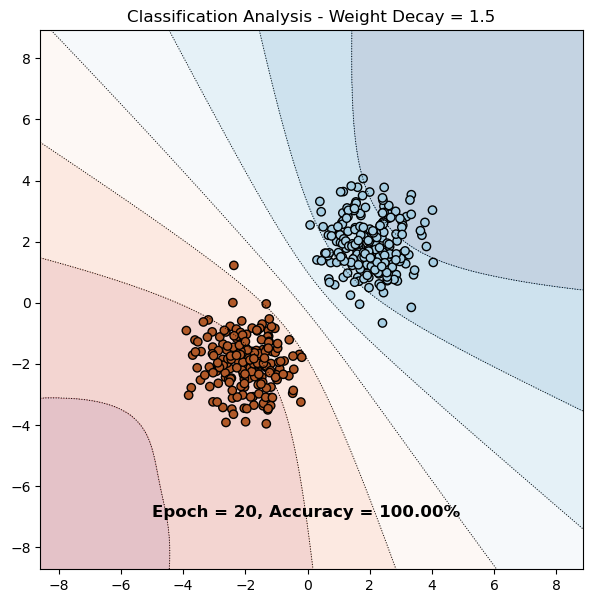

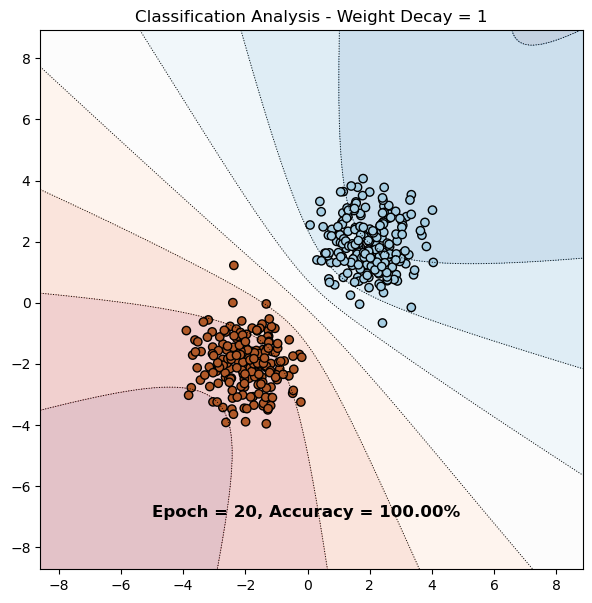

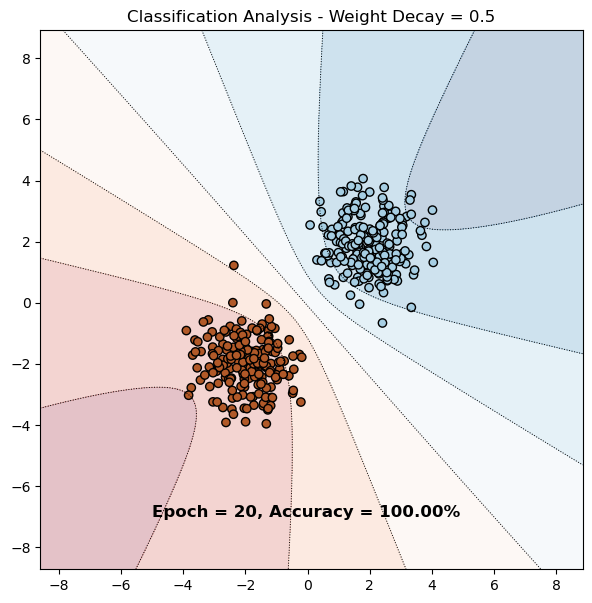

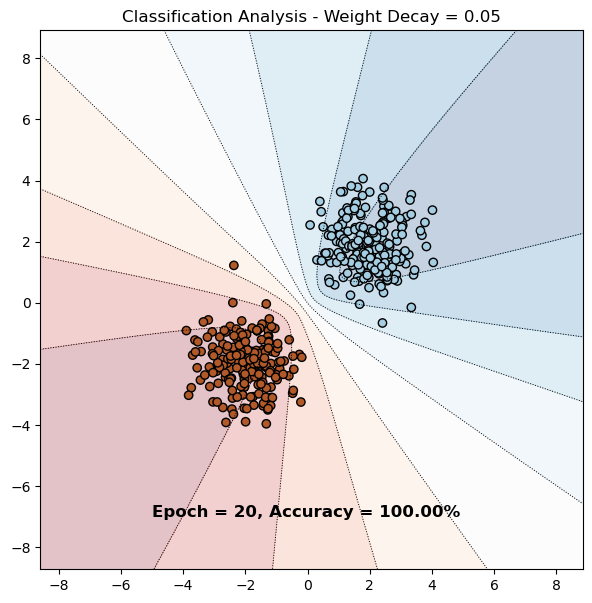

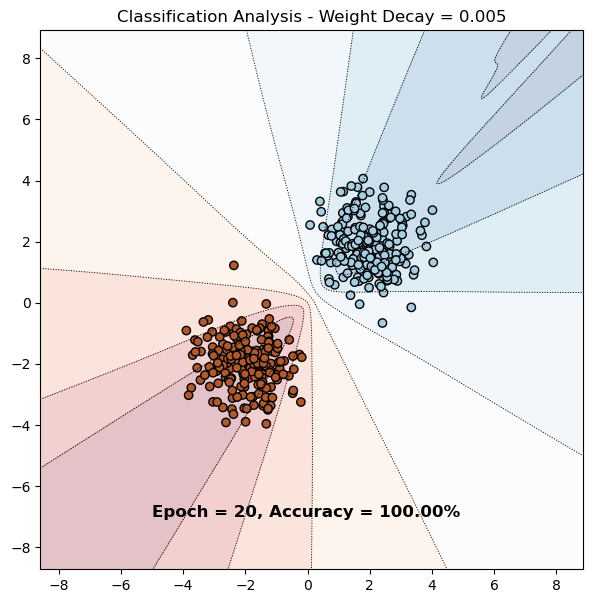

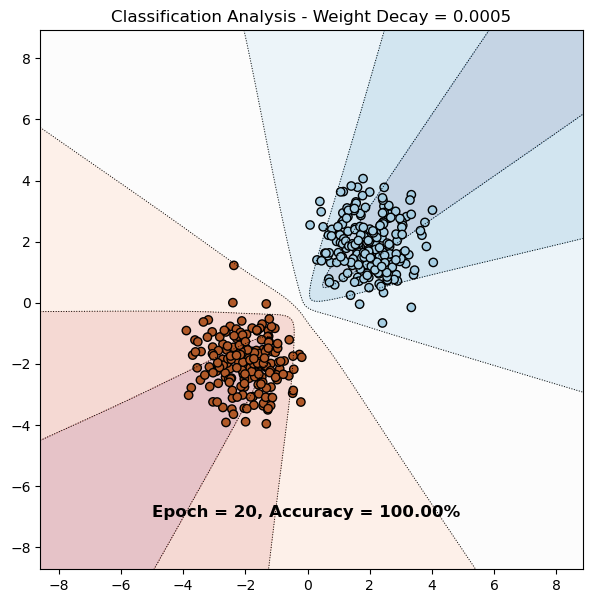

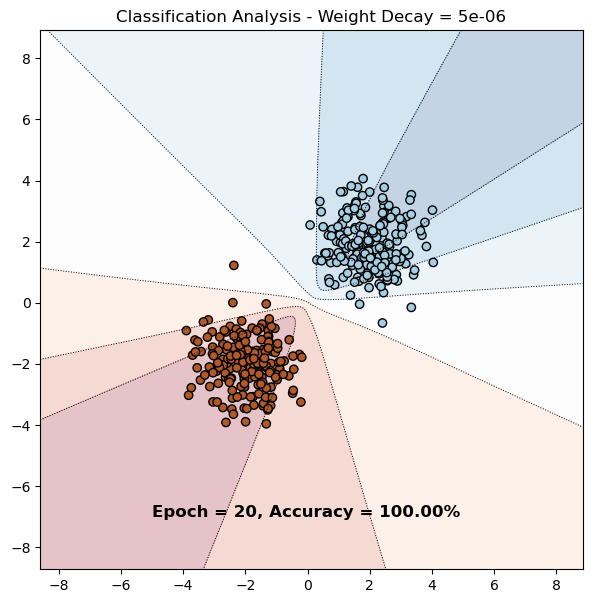

In [12]:
WEIGHT_DECAY = [1.5, 1, 0.5, 0.05, 0.005, 0.0005, 0.000005]

X_train = torch.tensor(X, dtype=torch.float32)  # Convertir en tenseur Float
y_train=torch.tensor(y, dtype=torch.long)

for W in WEIGHT_DECAY:
    net = LogisticRegression(input_size=X.shape[1])
    net.train()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=W)
    for epoch in range(20):  # loop over the dataset multiple times
        for X_batch, Y_batch in train_dataloader:  # Itérer sur les mini-batches
                    optimizer.zero_grad()
                    Yhat = net(X_batch).squeeze()  # Prédictions pour le batch actuel
                    L = criterion(Yhat, Y_batch)  # Calcul de la perte et de la précision
                    L.backward()
                    optimizer.step()
    
    w_map = net.fc.weight
    optimizer.zero_grad()
    output = net(X).squeeze()
    loss = criterion(output, y) + W*net.fc.weight.norm()**2
    gradf_weight = grad(loss, net.fc.weight, create_graph=True)[0]
    hess_weights = []
    for g in gradf_weight.view(-1):  
        hess_row = grad(g, net.fc.weight, retain_graph=True)[0]  
        hess_weights.append(hess_row.view(-1))  

    hess_weights = torch.stack(hess_weights).view(net.fc.weight.numel(), net.fc.weight.numel())

    epsilon = 1e-5
    Sigma_laplace = torch.inverse(hess_weights + epsilon * torch.eye(hess_weights.size(0)))

    # Defining posterior distribution
    laplace_posterior =  np.random.multivariate_normal(w_map.detach().numpy().reshape(2,), Sigma_laplace.detach().numpy(), NB_SAMPLES)
    # Plotting results
    fig, ax = plt.subplots(figsize=(7,7))
    plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.0) == y).float().mean(), model_type='laplace', 
                           tloc=TEXT_LOCATION, nsamples=NB_SAMPLES, posterior=laplace_posterior, comment=f'- Weight Decay = {W}')

Weight decay can be viewed as imposing a Gaussian prior on the weights, encouraging them to stay close to zero.  
The weight decay corresponds to the inverse of the prior variance $\sigma^2$. 

- **A smaller prior variance** $\sigma^2$ (or larger weight decay $\lambda$):  
  - Indicates strong confidence that the weights should be near zero.
  - Leads to a narrow prior, meaning the model has less flexibility to adapt to the data.  
  - This can result in **higher uncertainty** even in regions where data is abundant (as shown in the figures above), as the model is constrained in its ability to capture complexity.

- **A larger prior variance** $\sigma^2$ (or smaller weight decay $\lambda$):  
  - Allows the weights to take on larger values, enabling the model to fit the data more flexibly.
  - In regions where data is scarce or absent, this can lead to **higher uncertainty** (as shown in the figures above), because the model is less constrained by the prior and relies more on the data (likelihood) because the prior is "weak."


### I.3 Variational Inference

In this part, we will reimplement variational inference by hand with Pytorch tools. <br/><br/>

**Optimization problem**  
We define an approximating variational distribution $q_{\pmb{\theta}}(\pmb{w})$ parametrized by $\pmb{\theta}$ and minimize its Kullback-Leibler (KL) divergence with the unknown true posterior $p(\pmb{w} \vert \mathcal{D})$. This is equivalent to maximizing the **evidence lower bound (ELBO)** w.r.t to $q_{\pmb{\theta}}(\pmb{w})$:

$$ arg \max_{\pmb{\theta}}~ \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \big [\underbrace{\log p(\mathcal{D} \vert \pmb{w})}_{likelihood} \big ] - \underbrace{\textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))}_{regularization} $$
where we have a likelihood term  and the KL divergence between the prior and the variational distribution. By assuming that samples are *i.i.d*, maximizing the ELBO is equivalent to minimizing the following loss:
$$ \mathcal{L}_{\textrm{VI}}(\pmb{\theta}; \mathcal{D}) = - \sum_{n=1}^N \mathbb{E}_{q_{\pmb{\theta}}(\pmb{w})} \Big [ \log p(y_n \vert \pmb{x}_n, \pmb{w}) \Big ]+ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w})) = NLL(\pmb{\theta}; \mathcal{D}) + \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))$$


- **Likelihood term:** Computing the expectations for the negative log likelihhod $NLL(\pmb{\theta}; \mathcal{D})$ can be tedious mathematics, or maybe not even possible. 
    - **Monte Carlo estimator:** Luckily, we can get estimates of the expectations by taking samples from $q_{\pmb{\theta}}(\pmb{w})$ and average over those results. Even more simple, we can show that using only one sample is stil an unbiased gradient estimator. Hence, $NLL(\pmb{\theta}; \mathcal{D})$ rewrites:
$$ NLL(\pmb{\theta}; \mathcal{D}) =  \sum_{n=1}^N - \log p(y_n \vert \pmb{x}_n, \pmb{w}_s),$$ 
where $\pmb{w}_s \sim q_{\pmb{\theta}}$ is a sample from the variational distribution. <br><br>
 
- **Mean-field approximation:** Assumes a factorisation over weights: $ q_{\pmb{\theta}}(\pmb{w}) = \prod\limits_{i=1}^{N_w} q_{\pmb{\theta}}(w_{i}) =\prod\limits_{i=1}^{N_w} \mathcal{N}(w_{i}; \mu_{i}, \sigma^2_{i}) $. We use this Mean-field approximation for the variational posterior $q_{\pmb{\theta}}(\pmb{w})$ and the prior $p(\pmb{w})$. 
    - **Reparametrization trick:** If we start taking samples from $q_{\pmb{\theta}}$, we leave the deterministic world, and the gradient can not flow through the model anymore. We avoid this problem by reparameterizing the samples $\pmb{w}_{i} \sim \mathcal{N}(\mu_{i}, \sigma_{i}^2)$ from the distribution. Instead of sampling directly from the variational distribution, we sample from a centered isotropic multivariate Gaussian and recreate samples from the variational distribution. Now the stochasticity of $\pmb{\varepsilon}$ is external and will not prevent the flow of gradients: $\pmb{w}_{i} = \mu_{i}+ \sigma_{i}\odot\pmb{\varepsilon}_s$, where $\pmb{\varepsilon}_s \sim \mathcal{N}(0,1)$.
<br/><br>  
    - **Closed-for solution for the regularization term $ \textrm{KL}(q_{\pmb{\theta}}(\pmb{w})\vert\vert p(\pmb{w}))$**. For univariate Gaussian distribution, the KL term between the approximate variational distribution $q_{\theta}(w)\sim \mathcal{N}(\mu_{i},\sigma_{i}^2)$ and the prior $p(w)\sim \mathcal{N}(0,\sigma_{p}^2)$ rewrites: 

$$
\textrm{KL}\left[q_{\theta}(w))\vert\vert p(w) \right]= \sum\limits_{i=1}^d \left[ log\left(\frac{\sigma_{p}}{\sigma_{i}}\right) + \frac{\sigma_i^2+\mu_i^2}{2\sigma_{p}^2} - \frac{1}{2} \right]
$$

**Predictive distribution**  
For a new sample $\pmb{x^*}$, the predictive distribution can be approximated using **Monte Carlo sampling**:
\begin{equation}
p(\mathbf{y} =1|\pmb{x}^*,\mathcal{D}) \approx \int p(\mathbf{y} = 1|x^*,w)q_\theta^*(w) \approx \frac{1}{S} \sum_{s=1}^S p(\mathbf{y}=1|\pmb{x}^*,\pmb{w}_s)
\end{equation}
where $\pmb{w}_s \sim q^*_{\pmb{\theta}}$ are samples from the optimum variational distribution.

#### Step 1: Implement a variational layer

Let's first implement variational inference for a single layer. Remind that we defined our Logistic regression model as $f(x) = \sigma(w^T x + b)$ where $\sigma(t)= \frac{1}{1+\exp(t)}$ is the sigmoid function. As such, we need to place Gaussian distributions on parameters $w$ and $b$.  

**Implementation constraint:** Variance can not be negative. To avoid numerical issues, we will use $\rho$. Std can be retrieve with the following formula: $ \sigma^2 = \log(1 + e^{\rho}) $

In [13]:
# @title **[CODING TASK]** Implement a variational layer from scratch
class LinearVariational(nn.Module):
    """Mean field approximation of nn.Linear"""
    def __init__(self, input_size, output_size, prior_std):
        super().__init__()
        self.prior_std = prior_std  # \sigma_p
        
        # Initialize variational parameters for weights and bias
        self.w_mu = nn.Parameter(torch.zeros(input_size, output_size))  # Mean of weights
        self.w_rho = nn.Parameter(torch.zeros(input_size, output_size))  # Logarithm of sigma (rho)
        self.b_mu = nn.Parameter(torch.zeros(output_size))  # Bias, no variance assumed

    def sampling(self, mu, rho):
        """Sample weights using the reparametrization trick"""
        # Convert rho to standard deviation (sigma)
        sigma = torch.log1p(torch.exp(rho))  # Softplus to ensure positivity
        # Reparameterization trick: w = mu + sigma * epsilon
        epsilon = torch.randn_like(mu)
        return mu + sigma * epsilon

    def kl_divergence(self):
        """Compute KL divergence between all univariate posterior q(w)~N(mu_i, sigma_i) and prior p(w)~N(0, sigma_p)"""
        sigma = torch.log1p(torch.exp(self.w_rho))
        kl = (
            torch.log(self.prior_std / sigma) + 
            (sigma**2 + self.w_mu**2) / (2 * self.prior_std**2) - 0.5
        )
        return kl.sum()

    def forward(self, x):
        """Usual forward function for PyTorch layer"""
        # Sample weights and bias using reparameterization trick
        w_sample = self.sampling(self.w_mu, self.w_rho)
        b_sample = self.b_mu  # Bias assumed deterministic
        # Perform the forward pass
        out = torch.matmul(x, w_sample) + b_sample
        return out

#### Step 2: Variational Logistic Regression

Now, let's use this `LinearVariational` layer in a Logistic regression model.

In [14]:
class VariationalLogisticRegression(nn.Module):
    def __init__(self, input_size, prior_std=4.0):
        super().__init__()
        self.prior_std = prior_std
        self.fc_var = LinearVariational(input_size, 1, self.prior_std)
      
    def forward(self, x):
        out = self.fc_var(x)
        return torch.sigmoid(out)

    def kl_divergence(self):
        return self.fc_var.kl_divergence()

**[Question 1.4]: Comment the code of the VariationalLogisticRegression and LinearVariational classes.**

The `LinearVariational` class represents a single linear layer with variational inference applied. It approximates the weights and biases of the layer with distributions rather than fixed values.

- **Initialization (`__init__`):**
  - The class is initialized with variational parameters for the weights (`w_mu`, `w_rho`) and biases (`b_mu`) of the layer. These parameters define the variational posterior distribution $( q_\theta(w) \sim \mathcal{N}(\mu, \sigma^2) )$, which we aim to learn.
  - The `prior_std` parameter represents the standard deviation $( \sigma_p )$ of the prior distribution $( p(w) \sim \mathcal{N}(0, \sigma_p^2) )$, which reflects our prior belief about the weights.

- **Sampling (`sampling` method):**
  - This method uses the **reparameterization trick** to sample from the variational posterior distribution for the weights, $( w_i \sim \mathcal{N}(\mu_i, \sigma_i^2) )$.
  - The standard deviation $( \sigma )$ is computed as $( \sigma = \log(1 + \exp(\rho)) )$, a softplus function to ensure numerical stability.
  - Samples are drawn using $( w_i = \mu_i + \sigma_i \cdot \varepsilon_i )$, where $( \varepsilon_i \sim \mathcal{N}(0, 1) )$ is Gaussian noise. This reparametrization enables gradient flow through the stochastic sampling process.

- **KL Divergence (`kl_divergence` method):**
  - This method computes the Kullback-Leibler divergence between the variational posterior $( q_\theta(w) )$ and the prior $( p(w) )$. For a univariate Gaussian posterior, the KL divergence is given by:
    $$
    KL[q_\theta(w) \| p(w)] = \log\left(\frac{\sigma_p}{\sigma_i}\right) + \frac{\sigma_i^2 + \mu_i^2}{2\sigma_p^2} - \frac{1}{2}.
    $$

- **Forward Pass (`forward` method):**
  - The forward method performs a linear transformation $( xW + b )$, where $( W )$ and $( b )$ are sampled from their respective variational posteriors. 

The `VariationalLogisticRegression` class builds on the `LinearVariational` layer to implement a Bayesian logistic regression model:

- **Initialization (`__init__`):**
  - A single `LinearVariational` layer is initialized with an `input_size` corresponding to the number of features (2) and an output size of 1 for binary classification.

- **Forward Pass (`forward`):**
  - The model applies the `LinearVariational` layer to the input and uses the sigmoid function to output probabilities for binary classification.

- **KL Divergence (`kl_divergence`):**
  - Computes the KL divergence from the `LinearVariational` layer.

**We can now train our variational model as any other network in Pytorch**

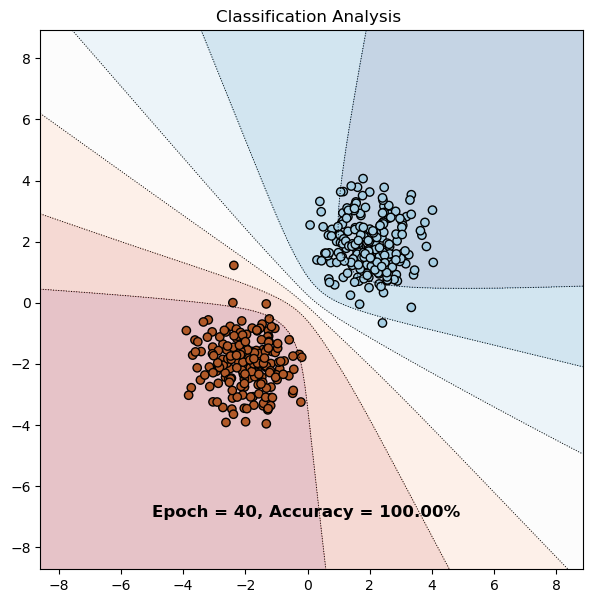

In [15]:
var_net = VariationalLogisticRegression(input_size=X.shape[1],prior_std=4)
var_net.train()
optimizer = torch.optim.SGD(var_net.parameters(), lr=0.1)
criterion = nn.BCELoss()

nbEpochs = 40
loss_plt = np.zeros((nbEpochs,3))

fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(nbEpochs): 
    optimizer.zero_grad()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    elbo = var_net.kl_divergence() + criterion(output, y)

    elbo.backward()
    optimizer.step()

    # Computing prediction for visualization purpose
    preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
    for i in range(NB_SAMPLES):
        preds[i] = var_net(X)
    pred = preds.mean(0).squeeze()
    accuracy = ((pred>=0.5) == y).float().mean()
    
    # For plotting and showing learning process at each epoch
    plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)

**[Question 1.5]: Comment the code of the training loop, especially the loss computation. Analyze the results provided by previous plot. Compared to previous MAP estimate, how does the predictive distribution behave? What is the main difference between the Variational approximation and the Laplace approximation?**

The training loop for the `VariationalLogisticRegression` model optimizes the **Evidence Lower Bound (ELBO)**, which combines two key terms: the KL divergence and the negative log-likelihood. 

- The **KL divergence** measures how much the variational posterior $q_\theta(w) \sim \mathcal{N}(\mu, \sigma^2)$ deviates from the prior $p(w) \sim \mathcal{N}(0, \sigma_p^2)$. This regularization term penalizes large deviations from the prior, ensuring that the model does not overfit by overconfidently assigning weights. It is computed in closed form using the mean and variance of the variational posterior for each weight.

- The **negative log-likelihood (NLL)** measures how well the model fits the observed data. For binary classification, it is computed using the binary cross-entropy loss: $-\sum_{i=1}^N \Big[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\Big] $, where $\hat{y}_i$ is the predicted probability from the sigmoid output. This term encourages the model to make predictions that align closely with the ground truth labels.

- In the training loop, the **negative ELBO** is minimized by summing the KL divergence and the NLL, with gradients flowing through both terms to update the variational parameters $( \mu, \rho, b)$ via backpropagation. Monte Carlo sampling is used to compute the predictive distribution, where weights are repeatedly sampled from the variational posterior, and the predictions are averaged to capture epistemic uncertainty.

Compared to the MAP estimate, which uses fixed weights and sharp decision boundaries, the variational method produces smoother decision boundaries and models uncertainty more effectively, particularly in regions far from the training data. Unlike the Laplace approximation, which assumes a Gaussian posterior centered at the MAP estimate and focuses on finding the MAP estimate and computing the Hessian at that location, the variational approach, on the other hand, directly optimizes the posterior distribution using a parametrized distribution, enabling scalability and better uncertainty quantification across the entire weight space. This leads to a more robust and probabilistic interpretation of the model’s predictions.

## Part II: Bayesian Neural Networks


Moving on to a non-linear dataset, we will leverage our variational implementation to a Multi-Layer Perceptron (MLP). Finally, we will also review one last approximate inference method which has the particularity to be very easy to implement: Monte-Carlo Dropout

### II.0 Dataset

In [16]:
# @title Hyperparameters for model and approximate inference { form-width: "30%" }
NOISE_MOON = 0.05 # @param
WEIGHT_DECAY = 5e-2 # @param
NB_SAMPLES = 100 # @param
TEXT_LOCATION = (-1.5, -1.5)

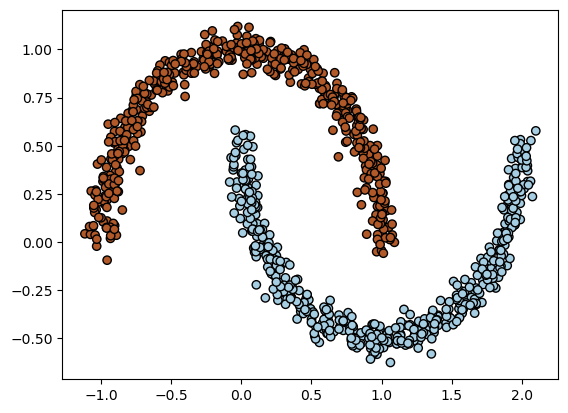

In [17]:
# Load two moons dataset
X, y = make_moons(n_samples=1000, noise=NOISE_MOON)
X, y = torch.from_numpy(X), torch.from_numpy(y)
X, y = X.type(torch.float), y.type(torch.float)
torch_train_dataset = data.TensorDataset(X,y) # create your datset
train_dataloader = data.DataLoader(torch_train_dataset, batch_size=len(torch_train_dataset))
N_DIM = X.shape[1]

# Visualize dataset
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k')
plt.show()

### II.1 Variational Inference with Bayesian Neural Networks

Such as for Logistic Regression, we will use `LinearVariational` layer to define a MLP with 1 hidden layer.





In [18]:
# @title **[CODING TASK]** Implement a Variational MLP
# Define a variational MLP with 1 hidden layer and ReLU activation
class VariationalMLP(nn.Module):
    def __init__(self, input_size, hidden_size, prior_std):
        super().__init__()
        self.prior_std = prior_std

        self.fc1 = LinearVariational(input_size, hidden_size, self.prior_std)
        self.fc2 = LinearVariational(hidden_size, 1, self.prior_std)
    
    def kl_divergence(self):
        return self.fc1.kl_divergence() + self.fc2.kl_divergence()
            
    def forward(self, x):
        # Don't forget to apply the sigmoid function when returning the output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

**We can now train our variational model as any other network in Pytorch**

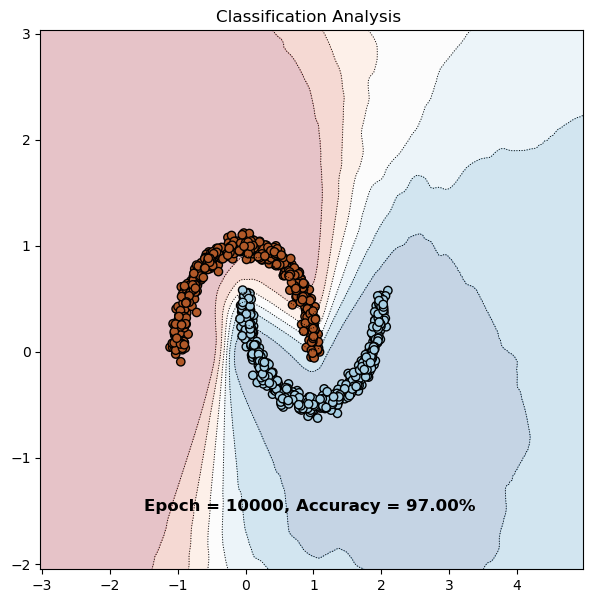

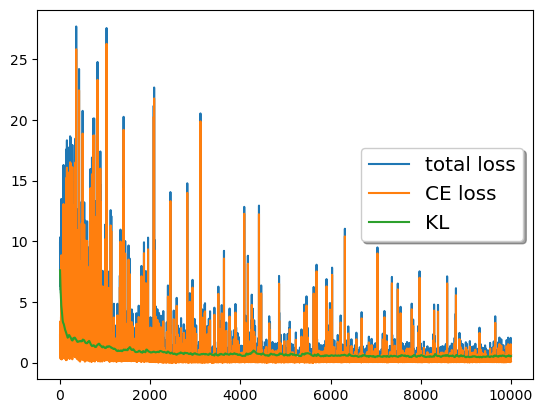

In [19]:
var_net = VariationalMLP(input_size=X.shape[1], hidden_size=50, prior_std=4)
var_net.train()
optimizer = torch.optim.Adam(var_net.parameters(), lr=0.1)

criterion = nn.BCELoss(reduction='mean')

nbEpochs = 10000
beta = 4e-2

loss_plt = np.zeros((nbEpochs,3))
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(nbEpochs):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = var_net(X).squeeze()
    elbo = beta * var_net.kl_divergence() + criterion(output, y)

    loss_plt[epoch, 0] = elbo
    loss_plt[epoch, 1] = criterion(output, y)
    loss_plt[epoch, 2] = beta * var_net.kl_divergence()
        
    elbo.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch
    if (epoch+1)%200==0:
        # Computing prediction for visualization purpose
        preds = torch.zeros(NB_SAMPLES, X.shape[0], 1)
        for i in range(NB_SAMPLES):
            preds[i] = var_net(X)
        pred = preds.mean(0).squeeze()
        accuracy = ((pred>=0.5) == y).float().mean()

        plot_decision_boundary(var_net, X, y, epoch, accuracy, model_type='vi', tloc=TEXT_LOCATION)
    
fig, ax = plt.subplots()
ax.plot(np.arange(nbEpochs),loss_plt[:,0], label='total loss')
ax.plot(np.arange(nbEpochs),loss_plt[:,1], label='CE loss')
ax.plot(np.arange(nbEpochs),loss_plt[:,2], label='KL')
legend = ax.legend(loc='center right', shadow=True, fontsize='x-large')

**[Question 2.1]: Analyze the results showed on plot.**

The loss plot shows that our full model implemented in Pytorch seems to be correctly learning from the data. Moreover, by implementing a simple neural network with one hidden layer, we observe the formation of complex, non-linear decision boundaries. The shaded regions indicating predictive uncertainty also adopt a non-linear shape. This aligns with our intuition about data uncertainty: predictions that lie close to previously seen data and follow its overall structure are more likely to be correct.

### II.2 Monte Carlo Dropout

Training a neural network with randomly dropping some activations, such as with dropout layers, can actually be seen as an **approximate variational inference method**!

[Gal and Ghahramani, 2016] showed this can be fullfilled for:
- $p(\pmb{w}) = \prod_l p(\pmb{W}_l) = \prod_l \mathcal{MN}(\pmb{W}_l; 0, I/ l_i^2, I)$ $\Rightarrow$ Multivariate Gaussian distribution factorized over layers
- $q(\pmb{w}) = \prod_l q(\pmb{W}_l) = \prod_l \textrm{diag}(\varepsilon_l)\odot\pmb{M}_l $ with $\varepsilon_l \sim \textrm{Ber}(1-p_l)$.

We will now implement a MLP with dropout layers and perform Monte-Carlo sampling to obtain the predictive distribution $p(\mathbf{y} \vert \pmb{x}^*, \pmb{w})$ for a new sample $\pmb{x}^*$.

In [20]:
# @title **[CODING TASK]** Implement a MLP with dropout (p=0.9)
# Code MLP with 1 hidden layer and a dropout layer. Be careful, the dropout
# layer should be also activated during test time.
# (Hint: we may want to look out at F.dropout())
class MLP(nn.Module):
    """ Pytorch MLP for binary classification model with an added dropout layer"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Don't forget to apply the sigmoid function when returning the output
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

We train our model as usual:

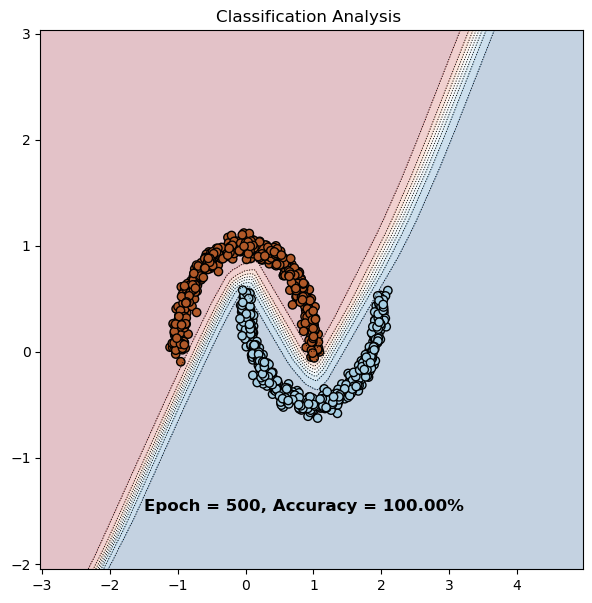

In [21]:
net = MLP(input_size=X.shape[1], hidden_size=50)
net.train()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
fig, ax = plt.subplots(figsize=(7,7))

for epoch in range(500):  # loop over the dataset multiple times
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    # For plotting and showing learning process at each epoch, uncomment and indent line below
    if (epoch+1)%50==0:
        plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='classic')

Now let's look at the results given by MC Dropout:

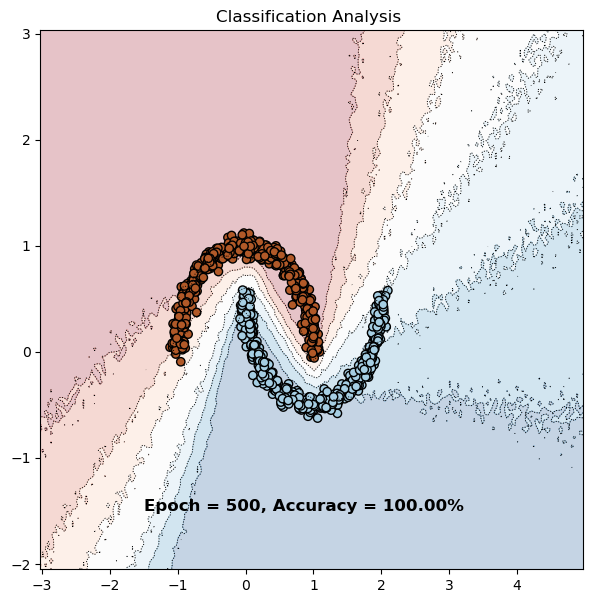

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
plot_decision_boundary(net, X, y, epoch, ((output.squeeze()>=0.5) == y).float().mean(), tloc=TEXT_LOCATION, model_type='mcdropout', nsamples=500)

**[Question 2.2]: Again, analyze the results showed on plot. What is the benefit of MC Dropout variational inference over Bayesian Logistic Regression with variational inference?**

In the previous figure, the model’s decision boundary is shown along with adjacent bands that represent varying levels of confidence. These bands arise through the use of dropout at inference and by averaging outputs over multiple stochastic passes. In contrast to the smooth gradients of deterministic neural networks (see second to last figure), this approach reveals how uncertainty changes throughout the input space. The speckled appearance of uncertainty regions can be attributed to the randomness introduced by Monte Carlo Dropout. By applying MC Dropout to a standard neural network, we effectively give it Bayesian-like properties, enabling it to provide uncertainty estimates alongside its predictions. This method not only yields more complex decision boundaries but also supplies a probabilistic view of the model’s reliability, facilitating more informed decisions based on the varying confidence across different input areas.